In [1]:
using LinearAlgebra
using Distributions
using DelimitedFiles
using BAT
using DataStructures
using CairoMakie
using DataFrames
using Interpolations
using CSV
using StatsBase

In [2]:
const datadir = @__DIR__ 

"/mnt/c/Users/peller/work/Newtrinos/src/experiments/icecube/deepcore_3y_highstats_sample_b"

In [3]:
function get_hkkm_flux(filename="spl-nu-20-01-000.d")    

    flux_chunks = []
    for i in 19:-1:0
        idx = i*103 + 3: (i+1)*103
        push!(flux_chunks, Float32.(readdlm(joinpath(datadir, "spl-nu-20-01-000.d"))[idx, 2:5]))
    end
    
    log10_energy_flux_values = LinRange(-1, 4, 101)
    
    cz_flux_bins = LinRange(-1, 1, 21);
    energy_flux_values = 10 .^ log10_energy_flux_values;
    
    cz_flux_values = LinRange(-0.95, 0.95, 20);
    
    hkkm_flux = permutedims(stack(flux_chunks), [1, 3, 2]);
    
    flux = OrderedDict()
    
    flux[:numu] = cubic_spline_interpolation((log10_energy_flux_values, cz_flux_values), hkkm_flux[:, :, 1], extrapolation_bc = Line());
    flux[:numubar] = cubic_spline_interpolation((log10_energy_flux_values, cz_flux_values), hkkm_flux[:, :, 2], extrapolation_bc = Line());
    flux[:nue] = cubic_spline_interpolation((log10_energy_flux_values, cz_flux_values), hkkm_flux[:, :, 3], extrapolation_bc = Line());
    flux[:nuebar] = cubic_spline_interpolation((log10_energy_flux_values, cz_flux_values), hkkm_flux[:, :, 4], extrapolation_bc = Line());

    return flux
end

get_hkkm_flux (generic function with 2 methods)

In [4]:
flux_splines = get_hkkm_flux()

OrderedDict{Any, Any} with 4 entries:
  :numu    => 101×20 extrapolate(scale(interpolate(OffsetArray(::Matrix{Float32…
  :numubar => 101×20 extrapolate(scale(interpolate(OffsetArray(::Matrix{Float32…
  :nue     => 101×20 extrapolate(scale(interpolate(OffsetArray(::Matrix{Float32…
  :nuebar  => 101×20 extrapolate(scale(interpolate(OffsetArray(::Matrix{Float32…

In [5]:
const L1 = 19.
const R = 6378.2 + L1
function cz_to_L(cz)
    zen = acos.(cz)
    phi = asin.((1-L1/R) * sin.(zen))
    psi = zen .- phi
    sqrt.((R-L1)^2 + R^2 .- (2*(R-L1) * R * cos.(psi)))
end

cz_to_L (generic function with 1 method)

In [6]:
const reco_energy_bin_edges = [5.623413,  7.498942, 10. , 13.335215, 17.782795, 23.713737, 31.622776, 42.16965 , 56.23413]
const reco_coszen_bin_edges = [-1., -0.75, -0.5 , -0.25,  0., 0.25, 0.5, 0.75, 1.]
const pid_bin_edges = -0.5:1:1.5
const type_bin_edges = [-0.5, 0.5, 3.5]

const cz_fine_bins = LinRange(-1,1, 201)
const log10e_fine_bins = LinRange(0,3,201)
const e_fine_bins = 10 .^log10e_fine_bins
const l_fine_bins = cz_to_L(cz_fine_bins);

const cz_fine = midpoints(cz_fine_bins);
const log10e_fine = midpoints(log10e_fine_bins);
const e_fine = 10 .^log10e_fine
const l_fine = midpoints(l_fine_bins)

200-element Vector{Float64}:
 12711.713670275858
 12584.342954326363
 12456.976185109565
 12329.613484565058
 12202.254979699868
 12074.900802853994
 11947.55109198283
 11820.205990957653
 11692.865649885622
 11565.530225450722
 11438.199881277269
 11310.874788317764
 11183.555125267003
     ⋮
    21.460788317465237
    21.221881276902234
    20.98822545033721
    20.759649885329353
    20.535990957356862
    20.317091982572045
    20.10280285376247
    19.892979699500643
    19.68748456465378
    19.486185109054027
    19.288954325880464
    19.0956702754912

In [7]:
mc_nu = CSV.read(joinpath("neutrino_mc.csv"), DataFrame; header=true);
mc_nu.log10_true_energy = log10.(mc_nu.true_energy)
mc_nu.l = cz_to_L(mc_nu.true_coszen);

In [8]:
function compute_indices(mc)
    mc.e_idx = searchsortedfirst.(Ref(reco_energy_bin_edges), mc.reco_energy) .- 1
    mc.c_idx = searchsortedfirst.(Ref(reco_coszen_bin_edges), mc.reco_coszen) .- 1
    mc.p_idx = searchsortedfirst.(Ref(pid_bin_edges), mc.pid) .- 1
    mc.t_idx = searchsortedfirst.(Ref(type_bin_edges), mc.type) .- 1
    mc.ef_idx = searchsortedfirst.(Ref(log10e_fine_bins), mc.log10_true_energy) .- 1
    mc.cf_idx = searchsortedfirst.(Ref(cz_fine_bins), mc.true_coszen) .- 1
end

compute_indices (generic function with 1 method)

In [9]:
compute_indices(mc_nu);

In [10]:
mc_nu

Row,pdg,pid,reco_coszen,reco_energy,true_coszen,true_energy,type,weight,log10_true_energy,l,e_idx,c_idx,p_idx,t_idx,ef_idx,cf_idx
,Int64,Int64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64
1,12,1,0.125,6.6,-0.166886,3.12526,3,1.95725e-10,0.494886,2237.35,1,5,2,2,33,84
2,12,0,-0.625,6.6,0.0840211,3.59735,2,2.87952e-10,0.555983,192.056,1,2,1,2,38,109
3,12,0,-0.375,8.7,-0.0245363,3.4476,2,2.56374e-10,0.537517,673.435,2,3,1,2,36,98
4,12,0,-0.125,11.7,-0.684406,2.93245,1,1.63997e-10,0.467231,8758.27,3,4,1,2,32,32
5,12,0,-0.625,8.7,0.0346757,2.99903,1,1.74413e-10,0.47698,318.876,2,2,1,2,32,104
6,12,0,-0.125,6.6,-0.230042,2.67212,3,1.27412e-10,0.426856,3015.01,1,4,1,2,29,77
7,12,0,0.875,8.7,0.640466,3.66991,2,3.04719e-10,0.564656,29.6028,2,8,1,2,38,165
8,12,1,0.125,6.6,-0.471117,3.7195,2,3.15472e-10,0.570484,6049.87,1,5,2,2,39,53
9,12,0,0.125,8.7,-0.257905,2.91426,2,1.6145e-10,0.464528,3362.13,2,5,1,2,31,75


In [11]:
function read_csv_into_hist(filename)
    csv = CSV.read(joinpath(datadir, filename), DataFrame; header=true)
    vars_to_extract = setdiff(names(csv), ("reco_coszen", "reco_energy", "pid"))
    d = OrderedDict()
    for var in vars_to_extract
        d[var] = fit(Histogram, (csv.reco_energy, csv.reco_coszen, csv.pid), weights(csv[:, var]), (reco_energy_bin_edges, reco_coszen_bin_edges, pid_bin_edges)).weights
    end
    d
end

read_csv_into_hist (generic function with 1 method)

In [12]:
muons = read_csv_into_hist("muons.csv")

OrderedDict{Any, Any} with 2 entries:
  "abs_uncert" => [1.21708 2.72346 … 1.52093 1.48547; 2.49286 3.4142 … 2.22315 …
  "count"      => [3.285 5.11 … 4.745 1.46; 4.015 5.84 … 9.855 4.745; … ; 4.015…

In [13]:
data = read_csv_into_hist("data.csv")

OrderedDict{Any, Any} with 1 entry:
  "count" => [254.0 418.0 … 100.0 31.0; 338.0 480.0 … 210.0 93.0; … ; 136.0 216…

In [14]:
const observed = data["count"]

8×8×2 Array{Float64, 3}:
[:, :, 1] =
 254.0  418.0  447.0  429.0  360.0  217.0  100.0   31.0
 338.0  480.0  623.0  600.0  531.0  380.0  210.0   93.0
 406.0  533.0  736.0  773.0  679.0  609.0  408.0  229.0
 395.0  550.0  668.0  778.0  728.0  669.0  533.0  366.0
 350.0  460.0  573.0  679.0  733.0  675.0  530.0  418.0
 239.0  302.0  430.0  498.0  560.0  538.0  429.0  307.0
 136.0  216.0  297.0  390.0  409.0  348.0  268.0  205.0
  98.0  150.0  197.0  239.0  252.0  215.0  177.0  112.0

[:, :, 2] =
 196.0  210.0  242.0  224.0  177.0   97.0   67.0   43.0
 176.0  171.0  247.0  206.0  197.0  136.0  103.0   66.0
 216.0  194.0  253.0  281.0  269.0  204.0  167.0  118.0
 177.0  208.0  262.0  336.0  374.0  299.0  202.0  175.0
 182.0  212.0  326.0  464.0  421.0  392.0  265.0  216.0
 133.0  217.0  342.0  496.0  454.0  360.0  267.0  177.0
 121.0  224.0  295.0  389.0  427.0  315.0  224.0  109.0
 129.0  192.0  242.0  313.0  281.0  226.0  139.0   58.0

In [15]:
hyperplanes = OrderedDict()
hyperplanes[:nuall_nc] = read_csv_into_hist("hyperplanes_all_nc.csv")
hyperplanes[:nue_cc] = read_csv_into_hist("hyperplanes_nue_cc.csv")
hyperplanes[:numu_cc] = read_csv_into_hist("hyperplanes_numu_cc.csv")
hyperplanes[:nutau_cc] = read_csv_into_hist("hyperplanes_nutau_cc.csv")

OrderedDict{Any, Any} with 6 entries:
  "ice_absorption"  => [0.00702571 0.00600796 … 0.0264721 0.0636833; 0.00237475…
  "ice_scattering"  => [-0.00573052 -0.00948726 … 0.0763472 0.0737333; -0.00940…
  "offset"          => [1.22676 1.42121 … -0.303146 9.03346; 1.3819 0.811742 … …
  "opt_eff_headon"  => [0.0301673 0.0347025 … 0.0877502 0.175533; 0.0309333 0.0…
  "opt_eff_lateral" => [-0.00700613 -0.00331234 … 0.002499 -0.0111869; -0.00568…
  "opt_eff_overall" => [-0.0477133 -0.25693 … 1.41498 -8.28126; -0.218251 0.313…

In [16]:
hyperplanes[:nue_cc]["opt_eff_overall"]

8×8×2 Array{Float64, 3}:
[:, :, 1] =
 1.00479  1.25713  1.02693  1.07465  1.00639  0.929    1.02503   1.49917
 1.29492  1.03965  1.07833  1.13926  1.14949  1.22016  0.827859  1.15347
 1.12806  1.30724  1.27271  1.2731   1.19311  1.16868  1.16481   0.97989
 1.47938  1.31358  1.33484  1.13096  1.28595  1.1881   1.18589   1.31766
 1.39776  1.40277  1.48994  1.06077  1.32816  1.12927  1.28991   1.36648
 1.65545  1.28965  1.14961  1.31957  1.32857  1.50957  1.53465   1.57099
 1.39847  1.46269  1.45113  1.33942  1.46177  1.26879  1.44445   1.30423
 1.64533  1.50937  1.46641  1.4874   1.60991  1.52857  1.52279   1.26192

[:, :, 2] =
 0.884378  1.07501  1.07216  1.11407   0.937232  0.997989  0.945051  1.74195
 1.20534   1.43393  1.23173  0.918484  1.00338   1.48058   1.0953    1.43408
 1.31875   1.52809  1.1879   1.40199   1.17899   1.30268   1.1419    0.953098
 1.51551   1.24103  1.58079  0.957298  1.42247   1.54096   1.29218   1.56798
 1.23011   1.38208  1.44946  1.19697   1.39311   1.42638 

In [17]:
mc = OrderedDict()

OrderedDict{Any, Any}()

In [18]:
mc[:nue] = mc_nu[mc_nu.pdg .== 12, :]
mc[:nuebar] = mc_nu[mc_nu.pdg .== -12, :]
mc[:numu] = mc_nu[mc_nu.pdg .== 14, :]
mc[:numubar] = mc_nu[mc_nu.pdg .== -14, :]
mc[:nutau] = mc_nu[mc_nu.pdg .== 16, :]
mc[:nutaubar] = mc_nu[mc_nu.pdg .== -16, :]

Row,pdg,pid,reco_coszen,reco_energy,true_coszen,true_energy,type,weight,log10_true_energy,l,e_idx,c_idx,p_idx,t_idx,ef_idx,cf_idx
,Int64,Int64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64
1,-16,0,0.625,8.7,0.850807,8.84088,2,2.92615e-9,0.946496,22.3191,2,7,1,2,64,186
2,-16,0,0.375,11.7,0.539387,7.90468,1,2.11229e-9,0.897885,35.0986,3,6,1,2,60,154
3,-16,0,-0.625,8.7,-0.112069,9.71287,2,3.81281e-9,0.987348,1582.94,2,2,1,2,66,89
4,-16,0,-0.625,15.6,-0.303866,8.74344,3,2.83453e-9,0.941682,3937.88,4,2,1,2,63,70
5,-16,0,0.125,6.6,0.550843,8.35092,2,2.48356e-9,0.921734,34.3758,1,5,1,2,62,156
6,-16,1,-0.625,8.7,-0.995494,9.3353,3,3.39872e-9,0.970128,12718.0,2,2,2,2,65,1
7,-16,0,-0.625,6.6,-0.761305,6.21679,2,1.04623e-9,0.793566,9736.45,1,2,1,2,53,24
8,-16,0,-0.375,6.6,-0.143835,9.11394,2,3.1859e-9,0.959706,1958.74,1,3,1,2,64,86
9,-16,0,-0.375,8.7,-0.729606,6.09981,1,9.82851e-10,0.785317,9333.15,2,3,1,2,53,28


In [19]:
channels = collect(keys(mc))

6-element Vector{Any}:
 :nue
 :nuebar
 :numu
 :numubar
 :nutau
 :nutaubar

In [49]:
function LogLogParam(true_energy, y1, y2, x1, x2, use_cutoff, cutoff_value)
    """ From https://github.com/icecube/pisa/blob/master/pisa/utils/barr_parameterization.py """
    nu_nubar = sign(y2)
    y1 = sign(y1) * log10(abs(y1) + 0.0001)
    y2 = log10(abs(y2 + 0.0001))
    modification = nu_nubar * 10. ^(((y2 - y1) / (x2 - x1)) * (log10(true_energy) - x1) + y1 - 2.)
    if use_cutoff
        modification *= exp(-1. * true_energy / cutoff_value)
    end
    return modification
end


function norm_fcn(x, sigma)
    """ From https://github.com/icecube/pisa/blob/master/pisa/utils/barr_parameterization.py """
    return 1. / sqrt(2 * pi * sigma^2) * exp(-x^2 / (2 * sigma^2))
end

norm_fcn (generic function with 1 method)

In [20]:
flavs = [:nue, :numu, :nutau]

3-element Vector{Symbol}:
 :nue
 :numu
 :nutau

(200, 200)

In [83]:
flux = OrderedDict()

OrderedDict{Any, Any}()

In [44]:
e = ones(size(cz_fine))' .* e_fine;
log10e = ones(size(cz_fine))' .* log10e_fine;
cz = cz_fine' .* ones(size(e_fine));

In [84]:
for key in [:nue, :numu]
    for anti in ["", "bar"]
        fkey = Symbol(key, anti)
            flux[fkey] = DataFrame(true_energy=[(e...)...], log10_true_energy=[(log10e...)...], true_coszen=[(cz...)...])
            flux[fkey][!, :flux] = flux_splines[fkey].(flux[fkey].log10_true_energy, flux[fkey].true_coszen);
            if key == :nue
                flux[fkey][!, "Barr_Ave"] = LogLogParam.(flux[fkey].true_energy, 5.5, 53., 0.5, 3., false, 0.)
                flux[fkey][!, "Barr_LogLog"] = LogLogParam.(flux[fkey].true_energy, 0.9, 10., 0.5, 2, true, 650.)
                flux[fkey][!, "Barr_norm_fcn"] = norm_fcn.(flux[fkey].true_coszen, 0.36)
            else
                flux[fkey][!, "Barr_Ave"] = LogLogParam.(flux[fkey].true_energy, 3, 43, 0.5, 3., false, 0.)
                flux[fkey][!, "Barr_LogLog"] = LogLogParam.(flux[fkey].true_energy, 0.6, 5, 0.5, 2., true, 1000.)
                flux[fkey][!, "Barr_norm_fcn"] = norm_fcn.(flux[fkey].true_coszen, 0.36)
            end
    end
end

In [52]:
# for ch in channels
#     for key in [:nue, :numu]
#         for anti in ["", "bar"]
#             fkey = Symbol(key, anti)
#             mc[ch][!, "flux_" * String(fkey)] = flux[fkey].(mc[ch].log10_true_energy, mc[ch].true_coszen);
#         end
#     end
# end

In [23]:
# for anti in ["", "bar"]
#     for flav in flavs
#         flav = Symbol(flav, anti)
#         for key in [:nue, :numu]
#             fkey = Symbol(key, anti)
#             mc[flav][!, "flux_" * String(key)] = flux[fkey].(mc[flav].log10_true_energy, mc[flav].true_coszen);
#             # precompute Barr stuff 
#             if key == :nue
#                 mc[flav][!, "Barr_Ave_" * String(key)] = LogLogParam.(mc[flav].true_energy, 5.5, 53., 0.5, 3., false, 0.)
#                 mc[flav][!, "Barr_LogLog_" * String(key)] = LogLogParam.(mc[flav].true_energy, 0.9, 10., 0.5, 2, true, 650.)
#             else
#                 mc[flav][!, "Barr_Ave_" * String(key)] = LogLogParam.(mc[flav].true_energy, 3, 43, 0.5, 3., false, 0.)
#                 mc[flav][!, "Barr_LogLog_" * String(key)] = LogLogParam.(mc[flav].true_energy, 0.6, 5, 0.5, 2., true, 1000.)
#                 mc[flav][!, "Barr_norm_fcn"] = norm_fcn.(mc[flav].true_coszen, 0.36)
#             end
#         end
#     end
# end

In [53]:
mc[:nue]

Row,pdg,pid,reco_coszen,reco_energy,true_coszen,true_energy,type,weight,log10_true_energy,l,e_idx,c_idx,p_idx,t_idx,ef_idx,cf_idx
,Int64,Int64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64
1,12,1,0.125,6.6,-0.166886,3.12526,3,1.95725e-10,0.494886,2237.35,1,5,2,2,33,84
2,12,0,-0.625,6.6,0.0840211,3.59735,2,2.87952e-10,0.555983,192.056,1,2,1,2,38,109
3,12,0,-0.375,8.7,-0.0245363,3.4476,2,2.56374e-10,0.537517,673.435,2,3,1,2,36,98
4,12,0,-0.125,11.7,-0.684406,2.93245,1,1.63997e-10,0.467231,8758.27,3,4,1,2,32,32
5,12,0,-0.625,8.7,0.0346757,2.99903,1,1.74413e-10,0.47698,318.876,2,2,1,2,32,104
6,12,0,-0.125,6.6,-0.230042,2.67212,3,1.27412e-10,0.426856,3015.01,1,4,1,2,29,77
7,12,0,0.875,8.7,0.640466,3.66991,2,3.04719e-10,0.564656,29.6028,2,8,1,2,38,165
8,12,1,0.125,6.6,-0.471117,3.7195,2,3.15472e-10,0.570484,6049.87,1,5,2,2,39,53
9,12,0,0.125,8.7,-0.257905,2.91426,2,1.6145e-10,0.464528,3362.13,2,5,1,2,31,75


In [62]:
flux[:nue]

Row,true_energy,log10_true_energy,true_coszen,flux,Barr_Ave,Barr_LogLog
,Float64,Float64,Float64,Float64,Float64,Float64
1,1.01742,0.0075,-0.995,71.2319,0.0351999,0.00407632
2,1.05317,0.0225,-0.995,64.4534,0.0356816,0.00417543
3,1.09018,0.0375,-0.995,58.2628,0.03617,0.00427695
4,1.1285,0.0525,-0.995,52.6543,0.036665,0.00438092
5,1.16815,0.0675,-0.995,47.6058,0.0371668,0.00448741
6,1.20921,0.0825,-0.995,43.0537,0.0376754,0.00459649
7,1.2517,0.0975,-0.995,38.9286,0.0381911,0.0047082
8,1.29569,0.1125,-0.995,35.1654,0.0387137,0.00482261
9,1.34122,0.1275,-0.995,31.7302,0.0392436,0.0049398


## ...data is now prepared...

In [25]:
# function reweight(mc, params, osc_prob)

#     p_nu = osc_prob(e_fine, l_fine, params);
#     p_nubar = osc_prob(e_fine, l_fine, params, anti=true);


#     osc_flux = OrderedDict()
    
#     for i in 1:3
#         flav = flavs[i]
#         p_nue_interp = linear_interpolation((log10e_fine, cz_fine), p_nu[:,:,1,i], extrapolation_bc = Flat());
#         p_numu_interp = linear_interpolation((log10e_fine, cz_fine), p_nu[:,:,2,i], extrapolation_bc = Flat());
    
#         p_nue = p_nue_interp.(mc[flav].log10_true_energy, mc[flav].true_coszen)
#         p_numu = p_numu_interp.(mc[flav].log10_true_energy, mc[flav].true_coszen)
    
#         osc_flux[flav] = p_nue .* mc[flav].flux_nue .+ p_numu .* mc[flav].flux_numu
#     end
    
#     for i in 1:3
#         flav = Symbol(flavs[i], "bar")
#         p_nue_interp = linear_interpolation((log10e_fine, cz_fine), p_nubar[:,:,1,i], extrapolation_bc = Flat());
#         p_numu_interp = linear_interpolation((log10e_fine, cz_fine), p_nubar[:,:,2,i], extrapolation_bc = Flat());
    
#         p_nue = p_nue_interp.(mc[flav].log10_true_energy, mc[flav].true_coszen)
#         p_numu = p_numu_interp.(mc[flav].log10_true_energy, mc[flav].true_coszen)
    
#         osc_flux[flav] = p_nue .* mc[flav].flux_nuebar .+ p_numu .* mc[flav].flux_numubar
#     end

#     osc_flux
# end

# Analysis

In [56]:
params_dict = OrderedDict()
params_dict[:deepcore_lifetime] = 2.5
params_dict[:deepcore_atm_muon_scale] = 1.
params_dict[:deepcore_ice_absorption] = 1.
params_dict[:deepcore_ice_scattering] = 1.
params_dict[:deepcore_opt_eff_overall] = 1.
params_dict[:deepcore_opt_eff_lateral] = 0.
params_dict[:deepcore_opt_eff_headon] = 0.
params_dict[:nc_norm] = 1.
params_dict[:nutau_cc_norm] = 1.
params_dict[:atm_flux_nunubar_ratio] = 1.
params_dict[:atm_flux_nueumu_ratio] = 1.
params_dict[:atm_flux_spectral_index] = 0.
params_dict[:Barr_uphor_ratio] = 0.0
params_dict[:Barr_nu_nubar_ratio ] = 0.

0.0

In [57]:
priors = OrderedDict()
priors[:deepcore_lifetime] = Uniform(2, 4)
priors[:deepcore_atm_muon_scale ] = Uniform(0, 2)
priors[:deepcore_ice_absorption] = Truncated(Normal(1, 0.1), 0.85, 1.15)
priors[:deepcore_ice_scattering] = Truncated(Normal(1, 0.1), 0.85, 1.15)
priors[:deepcore_opt_eff_overall] = Truncated(Normal(1, 0.1), 0.8, 1.2)
priors[:deepcore_opt_eff_lateral] = Truncated(Normal(0, 1.), -2, 2)
priors[:deepcore_opt_eff_headon] = Uniform(-5, 2.)
priors[:nc_norm] = Truncated(Normal(1, 0.2), 0.4, 1.6)
priors[:nutau_cc_norm] = Uniform(0., 2.)
priors[:atm_flux_nunubar_ratio] = 1.
priors[:atm_flux_nueumu_ratio] = Truncated(Normal(1., 0.05), 0.85, 1.15)
priors[:atm_flux_spectral_index] = Truncated(Normal(0., 0.1), -0.3, 0.3)
priors[:Barr_uphor_ratio] = Truncated(Normal(0., 1.), -3, 3)
priors[:Barr_nu_nubar_ratio] = Truncated(Normal(0., 1.), -3, 3)

Truncated(Normal{Float64}(μ=0.0, σ=1.0); lower=-3.0, upper=3.0)

In [58]:
using Newtrinos

In [99]:
using BenchmarkTools, ForwardDiff

In [59]:
p = NamedTuple(merge(Newtrinos.osc.standard.params, params_dict))

osc_prob = Newtrinos.osc.standard.osc_prob

osc_prob (generic function with 1 method)

# ToDo
- PREM / matter osc

In [60]:
function make_hist(e_idx, c_idx, p_idx, t_idx, w, size=(8,8,2,2))
    hist = similar(w, size)
    for i in 1:prod(size)
        hist[i] = 0.
    end
    for i in 1:length(w)
        hist[e_idx[i], c_idx[i], p_idx[i], t_idx[i]] += w[i]
    end
    hist
end

make_hist (generic function with 2 methods)

In [61]:
function make_hist_per_channel(mc, osc_flux, lifetime_seconds)
    w = lifetime_seconds * mc.weight .* osc_flux
    make_hist(mc.e_idx, mc.c_idx, mc.p_idx, mc.t_idx, w)
end

make_hist_per_channel (generic function with 1 method)

## Flux

In [68]:
function scale_flux(A::AbstractVector, B::AbstractVector, scale::Real)
    r = A ./ B
    total = A .+ B
    mod_B = total ./ (1 .+ r .* scale)
    mod_A = r .* scale .* mod_B
    return mod_A, mod_B  # Returns two separate vectors instead of tuples
end

scale_flux (generic function with 2 methods)

In [85]:
function Barr_factor_nue(Barr_Ave, Barr_LogLog, Barr_norm_fcn, nubar_sys, uphor)
    """ From https://github.com/icecube/pisa/blob/master/pisa/utils/barr_parameterization.py """
    # These parameters are obtained from fits to the paper of Barr
    # E dependent ratios, max differences per flavor (Fig.7)
    
    r_uphor = 1. .- 0.3 .* uphor .* Barr_LogLog .* Barr_norm_fcn
    r = Barr_Ave .- (1.5 .* Barr_norm_fcn .- 0.7) .* Barr_LogLog
    modfactor = nubar_sys .* r

    # nue, nuebar:
    return max.(0., 1. .+ 0.5 .* modfactor) .* r_uphor, max.(0., 1. ./ (1 .+ 0.5 .* modfactor)) .* r_uphor
        
    
end

function Barr_factor_numu(Barr_Ave, Barr_LogLog, Barr_norm_fcn, nubar_sys, uphor)
    """ From https://github.com/icecube/pisa/blob/master/pisa/utils/barr_parameterization.py """
    # These parameters are obtained from fits to the paper of Barr
    # E dependent ratios, max differences per flavor (Fig.7)

    r = Barr_Ave .- (Barr_norm_fcn .- 0.6) .* 2.5 .* Barr_LogLog
    modfactor = nubar_sys .* r

    # numu, numubar:
    max.(0., 1. .+ 0.5 .* modfactor), max.(0., 1. ./ (1 .+ 0.5 .* modfactor))
    
end

Barr_factor_numu (generic function with 1 method)

In [126]:
function calc_sys_flux(flux, params)

    # nu-nubar ratio:
    flux_nue1, flux_nuebar1 = scale_flux(flux[:nue].flux, flux[:nuebar].flux, params.atm_flux_nunubar_ratio)
    flux_numu1, flux_numubar1 = scale_flux(flux[:numu].flux, flux[:numubar].flux, params.atm_flux_nunubar_ratio)
    
    # nue-numu ratio:
    flux_nue2, flux_numu2 = scale_flux(flux_nue1, flux_numu1, params.atm_flux_nueumu_ratio)
    flux_nuebar2, flux_numubar2 = scale_flux(flux_nuebar1, flux_numubar1, params.atm_flux_nueumu_ratio)

    # spectral
    f_spectral_shift = (flux[:nue].true_energy ./ 24.0900951261) .^ params.atm_flux_spectral_index

    # Barr modifiers
    f_Barr_nue, f_Barr_nuebar = Barr_factor_nue(flux[:nue].Barr_Ave, flux[:nue].Barr_LogLog, flux[:nue].Barr_norm_fcn, params.Barr_nu_nubar_ratio, params.Barr_uphor_ratio)
    f_Barr_numu, f_Barr_numubarr = Barr_factor_nue(flux[:numu].Barr_Ave, flux[:numu].Barr_LogLog, flux[:numu].Barr_norm_fcn, params.Barr_nu_nubar_ratio, params.Barr_uphor_ratio)

    # apply:
    f_nue3 = flux_nue2 .* f_spectral_shift .* f_Barr_nue
    f_nuebar3 = flux_nuebar2 .* f_spectral_shift .* f_Barr_nuebar
    f_numu3 = flux_numu2 .* f_spectral_shift .* f_Barr_numu
    f_numubar3 = flux_numubar2 .* f_spectral_shift .* f_Barr_numubarr

    s = (size(e_fine)[1], size(cz_fine)[1])

    
    return (reshape(f_nue3, s), reshape(f_numu3, s)), (reshape(f_nuebar3, s), reshape(f_numubar3, s)) 
end

calc_sys_flux (generic function with 1 method)

In [127]:
@benchmark calc_sys_flux(flux, p)

BenchmarkTools.Trial: 3469 samples with 1 evaluation per sample.
 Range (min … max):  950.274 μs …  10.723 ms  ┊ GC (min … max):  0.00% …  0.00%
 Time  (median):       1.130 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):     1.430 ms ± 775.447 μs  ┊ GC (mean ± σ):  18.50% ± 20.70%

  ▂▅██▇▆▅▄▃▂▁                                     ▁▁▂▂▂▂▂▁▁▁    ▂
  ███████████▇▇▇▃▄▃▃▃▃▁▁▁▁▃▁▁▃▁▁▃▁▁▁▅▅▃▆▅▁▁▁▄▃▅▇▅▆███████████▇▇ █
  950 μs        Histogram: log(frequency) by time       3.68 ms <

 Memory estimate: 9.46 MiB, allocs estimate: 129.

In [94]:
# flux_nue_anti = scale_flux(mc.flux_nue, mc.flux_nuebar, params.atm_flux_nunubar_ratio)[Int(anti)+1]
# flux_numu_anti = scale_flux(mc.flux_numu, mc.flux_numubar, params.atm_flux_nunubar_ratio)[Int(anti)+1]

# # nue-numu ratio:
# flux_nue_i, flux_numu_i = scale_flux(flux_nue_anti, flux_numu_anti, params.atm_flux_nueumu_ratio)

# # spectral index
# f = (mc.true_energy ./ 24.0900951261) .^ params.atm_flux_spectral_index

# Barr_nue, Barr_numu = ModFlux(mc.Barr_Ave_nue, mc.Barr_Ave_numu, mc.Barr_LogLog_nue, mc.Barr_LogLog_numu, mc.Barr_norm_fcn, anti, params.Barr_nu_nubar_ratio, params.Barr_uphor_ratio)

# flux_nue_i * f * Barr_nue, flux_numu_i * f * Barr_numu

In [95]:
# function calc_sysflux_kernel(mc, params, anti)
#     # nu-nubar ratio
#     flux_nue_anti = scale_flux(mc.flux_nue, mc.flux_nuebar, params.atm_flux_nunubar_ratio)[Int(anti)+1]
#     flux_numu_anti = scale_flux(mc.flux_numu, mc.flux_numubar, params.atm_flux_nunubar_ratio)[Int(anti)+1]
    
#     # nue-numu ratio:
#     flux_nue_i, flux_numu_i = scale_flux(flux_nue_anti, flux_numu_anti, params.atm_flux_nueumu_ratio)
    
#     # spectral index
#     f = (mc.true_energy ./ 24.0900951261) .^ params.atm_flux_spectral_index

#     Barr_nue, Barr_numu = ModFlux(mc.Barr_Ave_nue, mc.Barr_Ave_numu, mc.Barr_LogLog_nue, mc.Barr_LogLog_numu, mc.Barr_norm_fcn, anti, params.Barr_nu_nubar_ratio, params.Barr_uphor_ratio)

#     flux_nue_i * f * Barr_nue, flux_numu_i * f * Barr_numu
# end

In [96]:
# function calc_sysflux_kernel_2(flux_nue, flux_nuebar, flux_numu, flux_numubar, true_energy, Barr_Ave_nue, Barr_Ave_numu, Barr_LogLog_nue, Barr_LogLog_numu, Barr_norm_fcn, params, anti)
#     # nu-nubar ratio
#     flux_nue_anti = scale_flux(flux_nue, flux_nuebar, params.atm_flux_nunubar_ratio)[Int(anti)+1]
#     flux_numu_anti = scale_flux(flux_numu, flux_numubar, params.atm_flux_nunubar_ratio)[Int(anti)+1]
    
#     # nue-numu ratio:
#     flux_nue_i, flux_numu_i = scale_flux(flux_nue_anti, flux_numu_anti, params.atm_flux_nueumu_ratio)
    
#     # spectral index
#     f = (true_energy ./ 24.0900951261) .^ params.atm_flux_spectral_index

#     Barr_nue, Barr_numu = ModFlux(Barr_Ave_nue, Barr_Ave_numu, Barr_LogLog_nue, Barr_LogLog_numu, Barr_norm_fcn, anti, params.Barr_nu_nubar_ratio, params.Barr_uphor_ratio)

#     flux_nue_i * f * Barr_nue, flux_numu_i * f * Barr_numu
# end

In [97]:
# function calc_sys_flux(mc, params, anti=false)
#     flux = stack([calc_sysflux_kernel(m, params, anti) for m in Tables.namedtupleiterator(mc)])
#     flux[1, :], flux[2, :]
# end

In [98]:
# function calc_sys_flux(mc, params, anti=false)
#     flux = stack(calc_sysflux_kernel_2.(mc.flux_nue, mc.flux_nuebar, mc.flux_numu, mc.flux_numubar, mc.true_energy, mc.Barr_Ave_nue, mc.Barr_Ave_numu, mc.Barr_LogLog_nue, mc.Barr_LogLog_numu, mc.Barr_norm_fcn, Ref(params), anti))
#     flux[1, :], flux[2, :]
# end

## Flux done

In [57]:
# function reweight_per_channel(p, mc, sys_flux_nue, sys_flux_numu, out)
#     pmce = [p[ef_idx, cf_idx, 1, out] for (ef_idx, cf_idx) in zip(mc.ef_idx, mc.cf_idx)]
#     pmcmu = [p[ef_idx, cf_idx, 2, out] for (ef_idx, cf_idx) in zip(mc.ef_idx, mc.cf_idx)]
#     return pmce .* sys_flux_nue .+ pmcmu .* sys_flux_numu   
# end

reweight_per_channel (generic function with 1 method)

In [58]:
# function reweight(mc, params, osc_prob)
#     p = [osc_prob(e_fine, l_fine, params), osc_prob(e_fine, l_fine, params, anti=true)]
#     res = OrderedDict()
#     for i in 1:length(channels)
#         anti = Bool((i+1)%2)
#         sys_flux_nue, sys_flux_numu = calc_sys_flux(mc[channels[i]], params, anti)
#         res[channels[i]] = reweight_per_channel(p[Int(anti)+1], mc[channels[i]], sys_flux_nue, sys_flux_numu, Int(ceil(i/2)))
#     end
#     res
# end

reweight (generic function with 1 method)

In [112]:
flavs

3-element Vector{Symbol}:
 :nue
 :numu
 :nutau

In [120]:
flux

OrderedDict{Any, Any} with 4 entries:
  :nue     => 40000×7 DataFrame…
  :nuebar  => 40000×7 DataFrame…
  :numu    => 40000×7 DataFrame…
  :numubar => 40000×7 DataFrame…

In [163]:
function reweight(mc, params, osc_prob)
    p = [osc_prob(e_fine, l_fine, params), osc_prob(e_fine, l_fine, params, anti=true)]
    f = calc_sys_flux(flux, params)
    res = OrderedDict()    
    for (i, flav) in enumerate(flavs)
        for (j, anti) in enumerate(["", "bar"])
            osc_flux = f[j][1] .* p[j][:, :, 1, i] .+ f[j][2] .* p[j][:, :, 2, i]
            ch = Symbol(flav, anti)
            res[ch] = [osc_flux[ef_idx, cf_idx] for (ef_idx, cf_idx) in zip(mc[ch].ef_idx, mc[ch].cf_idx)]
        end
    end
    res
end

reweight (generic function with 1 method)

In [164]:
@time reweight(mc, p, osc_prob)

  0.119684 seconds (193.19 k allocations: 47.501 MiB, 28.05% gc time, 61.91% compilation time)


OrderedDict{Any, Any} with 6 entries:
  :nue      => [5.77642, 4.01397, 5.08808, 3.06219, 7.32725, 8.0581, 1.73144, 1…
  :nuebar   => [2.5733, 2.16211, 4.02123, 1.9416, 2.69696, 2.89649, 10.3811, 15…
  :numu     => [3.38448, 8.39379, 6.56329, 3.57231, 2.99604, 0.304602, 2.67422,…
  :numubar  => [3.72679, 0.0567934, 4.38216, 12.1139, 0.303171, 5.74672, 1.8316…
  :nutau    => [0.898446, 0.0168392, 0.093185, 0.424419, 0.00050923, 0.199679, …
  :nutaubar => [1.47088e-5, 8.82932e-5, 0.0973253, 0.410397, 5.73362e-5, 0.1674…

In [165]:
function get_hyperplane_factor(hyperplane, params)
    f = (
        hyperplane["offset"] .+ 
        (hyperplane["ice_absorption"] * 100*(params.deepcore_ice_absorption -1)) .+ 
        (hyperplane["ice_scattering"] * 100*(params.deepcore_ice_scattering -1)) .+
        (hyperplane["opt_eff_overall"] .* params.deepcore_opt_eff_overall) .+
        (hyperplane["opt_eff_lateral"] * ((params.deepcore_opt_eff_lateral*10) +25.)) .+
        (hyperplane["opt_eff_headon"] * params.deepcore_opt_eff_headon)
        )
end

get_hyperplane_factor (generic function with 1 method)

In [166]:
hyperplanes

OrderedDict{Any, Any} with 4 entries:
  :nuall_nc => OrderedDict{Any, Any}("ice_absorption"=>[-0.000668132 -0.0040543…
  :nue_cc   => OrderedDict{Any, Any}("ice_absorption"=>[-0.00233225 0.000678494…
  :numu_cc  => OrderedDict{Any, Any}("ice_absorption"=>[-0.000787482 0.00030738…
  :nutau_cc => OrderedDict{Any, Any}("ice_absorption"=>[0.00702571 0.00600796 ……

In [167]:
function apply_hyperplanes(hists, params)
    sum = zeros(eltype(first(hists)[2]), size(first(hists)[2])[1:3])
    f_nc = get_hyperplane_factor(hyperplanes[:nuall_nc], params)
    for ch in channels
        if startswith(String(ch), "nue")
            f_cc = get_hyperplane_factor(hyperplanes[:nue_cc], params)
        elseif startswith(String(ch), "numu")
            f_cc = get_hyperplane_factor(hyperplanes[:numu_cc], params)
        else
            f_cc = get_hyperplane_factor(hyperplanes[:nutau_cc], params) .* params.nutau_cc_norm
        end        
        sum .+= hists[ch][:, :, :, 1] .* f_nc .* params.nc_norm
        sum .+= hists[ch][:, :, :, 2] .* f_cc
    end
    sum
end     

apply_hyperplanes (generic function with 1 method)

In [168]:
function get_expected(params, osc_prob)

    osc_flux = reweight(mc, params, osc_prob)

    lifetime_seconds = params.deepcore_lifetime * 365 * 24 * 3600

    hists = OrderedDict()

    for ch in channels
        hists[ch] = make_hist_per_channel(mc[ch], osc_flux[ch], lifetime_seconds)
    end
    
    expected_nu = apply_hyperplanes(hists, params)
    
    expected = (expected_nu .+ params.deepcore_atm_muon_scale .* muons["count"])
end

get_expected (generic function with 1 method)

In [169]:
@time get_expected(p, osc_prob)

  0.097328 seconds (45.75 k allocations: 51.910 MiB, 29.46% gc time, 54.23% compilation time)


8×8×2 Array{Float64, 3}:
[:, :, 1] =
 285.719  418.008  492.881  458.907  350.6    210.891   97.4264   30.9608
 359.556  506.899  616.555  608.796  519.019  367.618  221.1      94.3135
 424.599  574.143  702.592  732.174  694.428  562.691  402.469   233.29
 425.21   555.999  674.96   750.687  744.279  653.82   520.439   364.911
 359.284  469.897  585.191  674.508  678.357  611.832  512.503   387.388
 260.801  342.413  433.145  508.794  534.716  479.207  399.607   317.976
 178.212  231.731  294.809  356.81   366.796  325.626  270.585   210.868
 118.59   153.215  189.458  234.453  241.424  206.468  160.358   130.142

[:, :, 2] =
 197.376  223.672  255.411  238.996  179.406  113.571   67.3521   33.5123
 213.92   206.053  240.519  238.705  196.242  142.889  101.095    84.8845
 238.998  225.891  264.867  291.533  269.383  210.334  161.779   143.867
 240.995  233.035  296.772  357.034  350.34   290.35   229.185   193.379
 202.301  238.42   346.909  452.461  438.66   355.084  281.936   215.03

In [170]:
function forward_model(osc_prob)
    model = params -> begin
        exp_events = get_expected(params, osc_prob)
        distprod(Poisson.(exp_events))
    end
end

forward_model (generic function with 1 method)

# Testing

In [171]:
fwd_mod = forward_model(osc_prob)

#26 (generic function with 1 method)

In [172]:
@time logpdf(fwd_mod(p), data["count"])

  0.032909 seconds (25.68 k allocations: 50.940 MiB, 36.51% gc time, 23.97% compilation time)


-587.6399262076891

In [173]:
using DensityInterface

In [174]:
llh = let osc_prob = osc_prob, observed = observed
        params -> logpdf(forward_model(osc_prob)(params), observed)
end

l = logfuncdensity(params -> llh(params))

LogFuncDensity(var"#30#31"())

In [175]:
@time logdensityof(l, p)

  0.039404 seconds (2.74 k allocations: 49.836 MiB, 33.31% gc time, 33.54% compilation time)


-587.6399262076891

In [176]:
using ForwardDiff

In [177]:
g(p) = ForwardDiff.gradient(p -> logdensityof(l, p), p)

g (generic function with 1 method)

In [178]:
@benchmark logdensityof(l, p)

BenchmarkTools.Trial: 352 samples with 1 evaluation per sample.
 Range (min … max):  11.069 ms … 27.760 ms  ┊ GC (min … max):  0.00% … 9.58%
 Time  (median):     14.288 ms              ┊ GC (median):    16.35%
 Time  (mean ± σ):   14.194 ms ±  1.787 ms  ┊ GC (mean ± σ):  12.66% ± 7.22%

                         ▃▄▃█▇▂                                
  ▃▂▅▅▇▅▅▅▄▄▃▄▃▃▃▂▄▄▃▄▅▆██████████▅▆▄▅▆▄▆▅▄▃▁▂▃▁▂▁▂▁▁▁▁▁▁▂▂▁▂ ▃
  11.1 ms         Histogram: frequency by time        18.3 ms <

 Memory estimate: 49.74 MiB, allocs estimate: 737.

In [179]:
@benchmark g(p)

BenchmarkTools.Trial: 14 samples with 1 evaluation per sample.
 Range (min … max):  254.500 ms … 432.903 ms  ┊ GC (min … max):  3.89% … 39.46%
 Time  (median):     411.769 ms               ┊ GC (median):    39.94%
 Time  (mean ± σ):   362.172 ms ±  72.508 ms  ┊ GC (mean ± σ):  27.94% ± 18.56%

  ▁ ▁   ▁  ▁      ▁           ▁                        ▁▁▁█ █ ▁  
  █▁█▁▁▁█▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████▁█▁█ ▁
  255 ms           Histogram: frequency by time          433 ms <

 Memory estimate: 1.03 GiB, allocs estimate: 1726.

In [180]:
using BAT
using Optim

- ice_absorption : slope accounting for differences in ice optical absorption, nominal parameter values is 1, the uncertainty +/- 0.1 and the valid range +/- 0.15
- ice_scattering : slope accounting for differences in ice optical scattering, nominal parameter values is 1, the uncertainty +/- 0.1 and the valid range +/- 0.15
- opt_eff_overall : slope accounting for overall optical efficiency of DOMs, nominal parameter value is 1, the uncertainty +/- 0.1 and the valid range is +/- 0.2
- opt_eff_lateral : slope accounting for lateral optical efficiency of DOMs, nominal parameter value is 0, the uncertainty +/- 1 and the valid range is +/- 2
- opt_eff_headon : slope accounting for head-on optical efficiency of DOMs, nominal parameter value is 0, the uncertainty unknown (flat) and the valid range is [-5.0, +2.0]


In [181]:
prior = distprod(;merge(Newtrinos.osc.standard.priors, priors)...)

NamedTupleDist((θ₁₂ = Uniform{Float64}(a=0.4205343352839651, b=0.7853981633974483), θ₁₃ = Uniform{Float64}(a=0.1, b=0.2), θ₂₃ = Uniform{Float64}(a=0.5235987755982988, b=1.0471975511965976), δCP = Uniform{Float64}(a=0.0, b=6.283185307179586), Δm²₂₁ = Uniform{Float64}(a=6.5e-5, b=9.0e-5), Δm²₃₁ = Uniform{Float64}(a=0.002, b=0.003), deepcore_lifetime = Uniform{Float64}(a=2.0, b=4.0), deepcore_atm_muon_scale = Uniform{Float64}(a=0.0, b=2.0), deepcore_ice_absorption = Truncated(Normal{Float64}(μ=1.0, σ=0.1); lower=0.85, upper=1.15), deepcore_ice_scattering = Truncated(Normal{Float64}(μ=1.0, σ=0.1); lower=0.85, upper=1.15), deepcore_opt_eff_overall = Truncated(Normal{Float64}(μ=1.0, σ=0.1); lower=0.8, upper=1.2), deepcore_opt_eff_lateral = Truncated(Normal{Float64}(μ=0.0, σ=1.0); lower=-2.0, upper=2.0), deepcore_opt_eff_headon = Uniform{Float64}(a=-5.0, b=2.0), nc_norm = Truncated(Normal{Float64}(μ=1.0, σ=0.2); lower=0.4, upper=1.6), nutau_cc_norm = Uniform{Float64}(a=0.0, b=2.0), atm_flux_n

In [182]:
posterior = PosteriorMeasure(l, prior)

PosteriorMeasure(objectid = 0xe761110658433de7, varshape = NamedTupleShape((:θ₁₂, :θ₁₃, :θ₂₃, :δCP, :Δm²₂₁, :Δm²₃₁, :deepcore_lifetime, :deepcore_atm_muon_scale, :deepcore_ice_absorption, :deepcore_ice_scattering, :deepcore_opt_eff_overall, :deepcore_opt_eff_lateral, :deepcore_opt_eff_headon, :nc_norm, :nutau_cc_norm, :atm_flux_nunubar_ratio, :atm_flux_nueumu_ratio, :atm_flux_spectral_index, :Barr_uphor_ratio, :Barr_nu_nubar_ratio)}(…))

In [183]:
using ADTypes

In [184]:
set_batcontext(ad = AutoForwardDiff())

[ Info: Setting new default BAT context BATContext{Float64}(Random123.Philox4x{UInt64, 10}(0xb178260b3117addd, 0x702671f4251fbd93, 0x8e0010a546f5753c, 0xda4bd5c9b81a5f43, 0x39c13ed45e9b27a4, 0x789939ea9c1f3b9f, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0), HeterogeneousComputing.CPUnit(), BAT._NoADSelected())


BATContext{Float64}(Random123.Philox4x{UInt64, 10}(0xb178260b3117addd, 0x702671f4251fbd93, 0x8e0010a546f5753c, 0xda4bd5c9b81a5f43, 0x39c13ed45e9b27a4, 0x789939ea9c1f3b9f, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0), HeterogeneousComputing.CPUnit(), AutoForwardDiff())

In [185]:
rand(prior)

(θ₁₂ = 0.7033173305617224, θ₁₃ = 0.18745180005600282, θ₂₃ = 1.0311945531014937, δCP = 3.384504099039646, Δm²₂₁ = 8.1166885926606e-5, Δm²₃₁ = 0.0023585669079012554, deepcore_lifetime = 2.9850382966416493, deepcore_atm_muon_scale = 1.9748031631088965, deepcore_ice_absorption = 0.8608182545109212, deepcore_ice_scattering = 0.9128535908101798, deepcore_opt_eff_overall = 0.9891459015786002, deepcore_opt_eff_lateral = 0.7676526701996216, deepcore_opt_eff_headon = -3.4728605170292894, nc_norm = 0.6599138923463743, nutau_cc_norm = 0.20037197717205668, atm_flux_nunubar_ratio = 1.0, atm_flux_nueumu_ratio = 1.0062786856789723, atm_flux_spectral_index = -0.03750815720276247, Barr_uphor_ratio = 0.20993095858453895, Barr_nu_nubar_ratio = -0.1555267425186158)

In [186]:
params

params (generic function with 99 methods)

In [188]:
logdensityof(l, p)

-587.6399262076891

In [190]:
logdensityof(posterior, p)

-566.1023519748553

In [191]:
@time res = bat_findmode(posterior, OptimAlg(optalg=Optim.LBFGS()))

510.224850 seconds (29.32 M allocations: 1.355 TiB, 27.89% gc time, 1.41% compilation time)


@NamedTuple{result::NamedTuple, result_trafo::Vector, trafo::Function, info, optargs::@NamedTuple{algorithm::OptimAlg{LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}, PriorToGaussian, InitFromTarget}, context::BATContext{Float64, Random123.Philox4x{UInt64, 10}, HeterogeneousComputing.CPUnit, AutoForwardDiff{nothing, Nothing}}}}(((θ₁₂ = 0.7853981633974483, θ₁₃ = 0.1, θ₂₃ = 0.788272671834618, δCP = 3.6476026629124356, Δm²₂₁ = 8.999999999999999e-5, Δm²₃₁ = 0.002323490606078901, deepcore_lifetime = 2.3000620448607267, deepcore_atm_muon_scale = 0.9503068402535904, deepcore_ice_absorption = 1.0148457088566056, deepcore_ice_scattering = 0.967920447819459, deepcore_opt_eff_overall = 1.0618994335659648, deepcore_opt_eff_lateral = -0.42427983778618666, deepcore_opt_eff_headon = -1.359223758812921, nc_norm = 1.2974148014895803, nutau_cc_norm = 0.30227360306123696, atm_flux_nunubar_ratio = 1.0, atm_flux_nueumu_ratio = 1.

In [192]:
for key in keys(res.result)
    @printf("%s: %.5f\n", key, res.result[key])
end

θ₁₂: 0.78540
θ₁₃: 0.10000
θ₂₃: 0.78827
δCP: 3.64760
Δm²₂₁: 0.00009
Δm²₃₁: 0.00232
deepcore_lifetime: 2.30006
deepcore_atm_muon_scale: 0.95031
deepcore_ice_absorption: 1.01485
deepcore_ice_scattering: 0.96792
deepcore_opt_eff_overall: 1.06190
deepcore_opt_eff_lateral: -0.42428
deepcore_opt_eff_headon: -1.35922
nc_norm: 1.29741
nutau_cc_norm: 0.30227
atm_flux_nunubar_ratio: 1.00000
atm_flux_nueumu_ratio: 1.03871
atm_flux_spectral_index: -0.01486
Barr_uphor_ratio: -0.34615
Barr_nu_nubar_ratio: 0.04873


In [193]:
res.result.θ₂₃ / pi * 180

45.16469720162457

In [194]:
samples = bat_sample(posterior, MCMCSampling(mcalg = MetropolisHastings(), nsteps = 10^4, nchains = 4)).result

[ Info: MCMCChainPoolInit: trying to generate 4 viable MCMC chain(s).
[ Info: Selected 4 MCMC chain(s).
[ Info: Begin tuning of 4 MCMC chain(s).
[ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 3 finished, 4 chains, 3 tuned, 0 converged.
[ Info: MCMC Tuning cycle 4 finished, 4 chains, 2 tuned, 0 converged.
[ Info: MCMC Tuning cycle 5 finished, 4 chains, 3 tuned, 0 converged.
[ Info: MCMC Tuning cycle 6 finished, 4 chains, 3 tuned, 0 converged.
[ Info: MCMC Tuning cycle 7 finished, 4 chains, 3 tuned, 0 converged.
[ Info: MCMC Tuning cycle 8 finished, 4 chains, 4 tuned, 0 converged.
[ Info: MCMC Tuning cycle 9 finished, 4 chains, 4 tuned, 0 converged.
[ Info: MCMC Tuning cycle 10 finished, 4 chains, 4 tuned, 0 converged.
[ Info: MCMC Tuning cycle 11 finished, 4 chains, 4 tuned, 0 converged.
[ Info: MCMC Tuning cycle 12 finished, 4 chains, 4 tuned, 0 converged.
[ Info: MCMC

DensitySampleVector, StructArray with 5 columns and 10947 rows:
      v                       logd      weight  info                    aux
    ┌──────────────────────────────────────────────────────────────────────────
 1  │ (θ₁₂ = 0.463298, θ₁₃ …  -527.262  2       MCMCSampleID(3, 27, 0…  nothing
 2  │ (θ₁₂ = 0.465328, θ₁₃ …  -527.4    2       MCMCSampleID(3, 27, 2…  nothing
 3  │ (θ₁₂ = 0.466362, θ₁₃ …  -526.992  2       MCMCSampleID(3, 27, 4…  nothing
 4  │ (θ₁₂ = 0.451743, θ₁₃ …  -527.444  1       MCMCSampleID(3, 27, 6…  nothing
 5  │ (θ₁₂ = 0.504659, θ₁₃ …  -529.238  2       MCMCSampleID(3, 27, 7…  nothing
 6  │ (θ₁₂ = 0.536128, θ₁₃ …  -528.009  2       MCMCSampleID(3, 27, 9…  nothing
 7  │ (θ₁₂ = 0.510145, θ₁₃ …  -527.188  3       MCMCSampleID(3, 27, 1…  nothing
 8  │ (θ₁₂ = 0.436834, θ₁₃ …  -526.235  1       MCMCSampleID(3, 27, 1…  nothing
 9  │ (θ₁₂ = 0.439832, θ₁₃ …  -526.496  8       MCMCSampleID(3, 27, 1…  nothing
 10 │ (θ₁₂ = 0.426368, θ₁₃ …  -525.538  1       MCMCSampleID

In [198]:
fig = plot(samples)
save("deepcore.png", fig)

In [200]:
sin(0.9)^2

0.6136010473465435

In [155]:
using Printf

In [156]:
e_ticks = (reco_energy_bin_edges, [@sprintf("%.1f",b) for b in reco_energy_bin_edges])

([5.623413, 7.498942, 10.0, 13.335215, 17.782795, 23.713737, 31.622776, 42.16965, 56.23413], ["5.6", "7.5", "10.0", "13.3", "17.8", "23.7", "31.6", "42.2", "56.2"])

In [157]:
function plotmap(h; colormap=Reverse(:Spectral), symm=false)

    if symm
        colorrange = (-maximum(abs.(h)), maximum(abs.(h)))
    else
        colorrange = (0, maximum(h))
    end
    
    fig = Figure(size=(800, 400))
    ax = Axis(fig[1,1], xscale=log10, xticks=e_ticks, xlabel="E (GeV)", ylabel="cos(zen)", title="cascades")
    hm = heatmap!(ax, reco_energy_bin_edges, reco_coszen_bin_edges, h[:, :, 1], colormap=colormap, colorrange=colorrange)
    ax = Axis(fig[1,2], xscale=log10, xticks=e_ticks, xlabel="E (GeV)", yticksvisible=true, yticklabelsvisible=false, title="tracks")
    hm = heatmap!(ax, reco_energy_bin_edges, reco_coszen_bin_edges, h[:, :, 2], colormap=colormap, colorrange=colorrange)
    Colorbar(fig[1,3], hm)
    fig
end

plotmap (generic function with 1 method)

In [159]:
expected = get_expected(p, osc_prob);

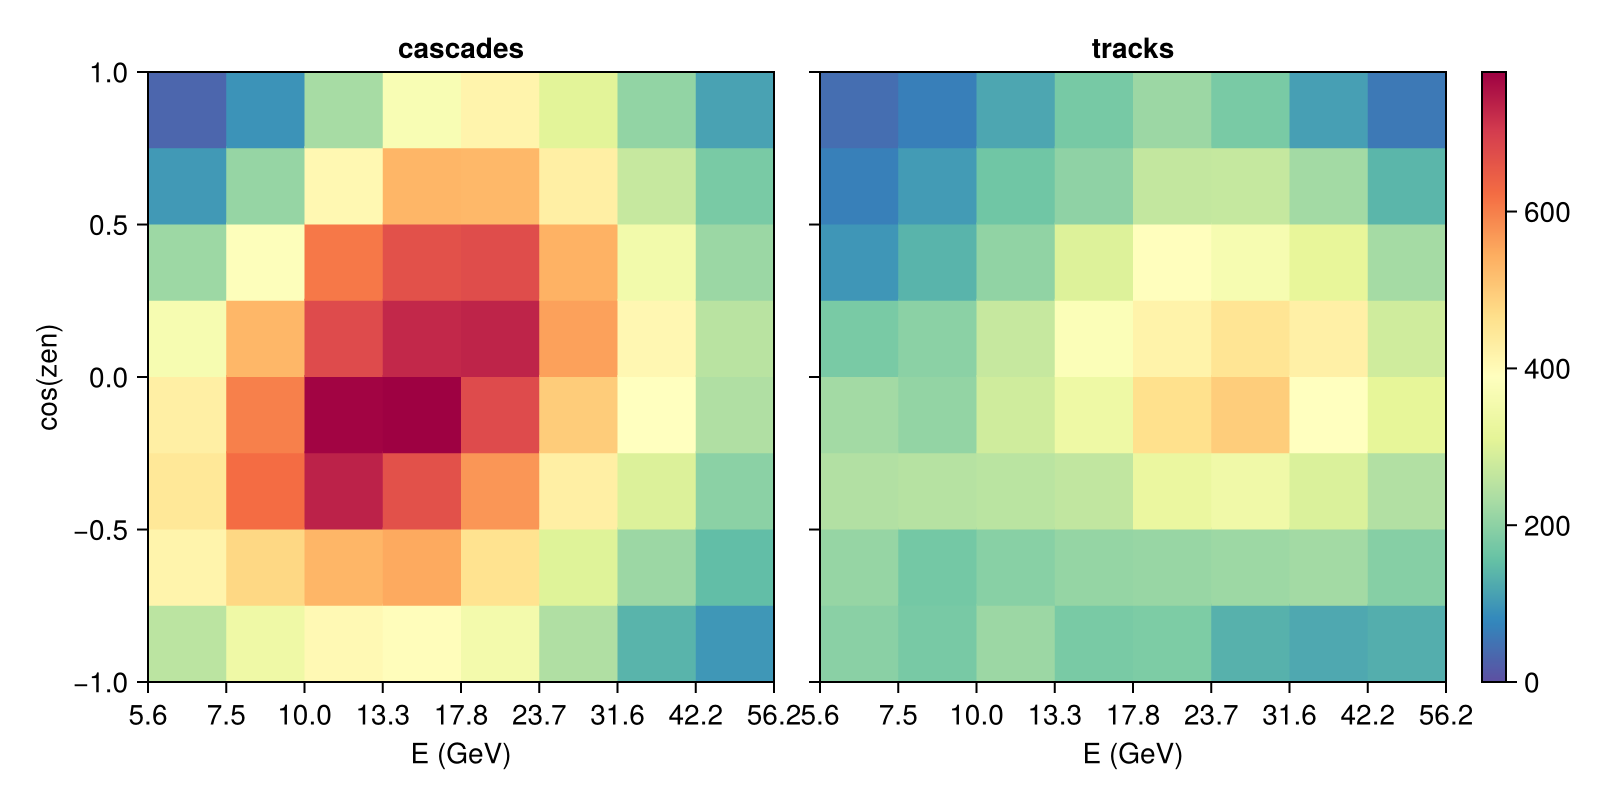

In [161]:
plotmap(observed)

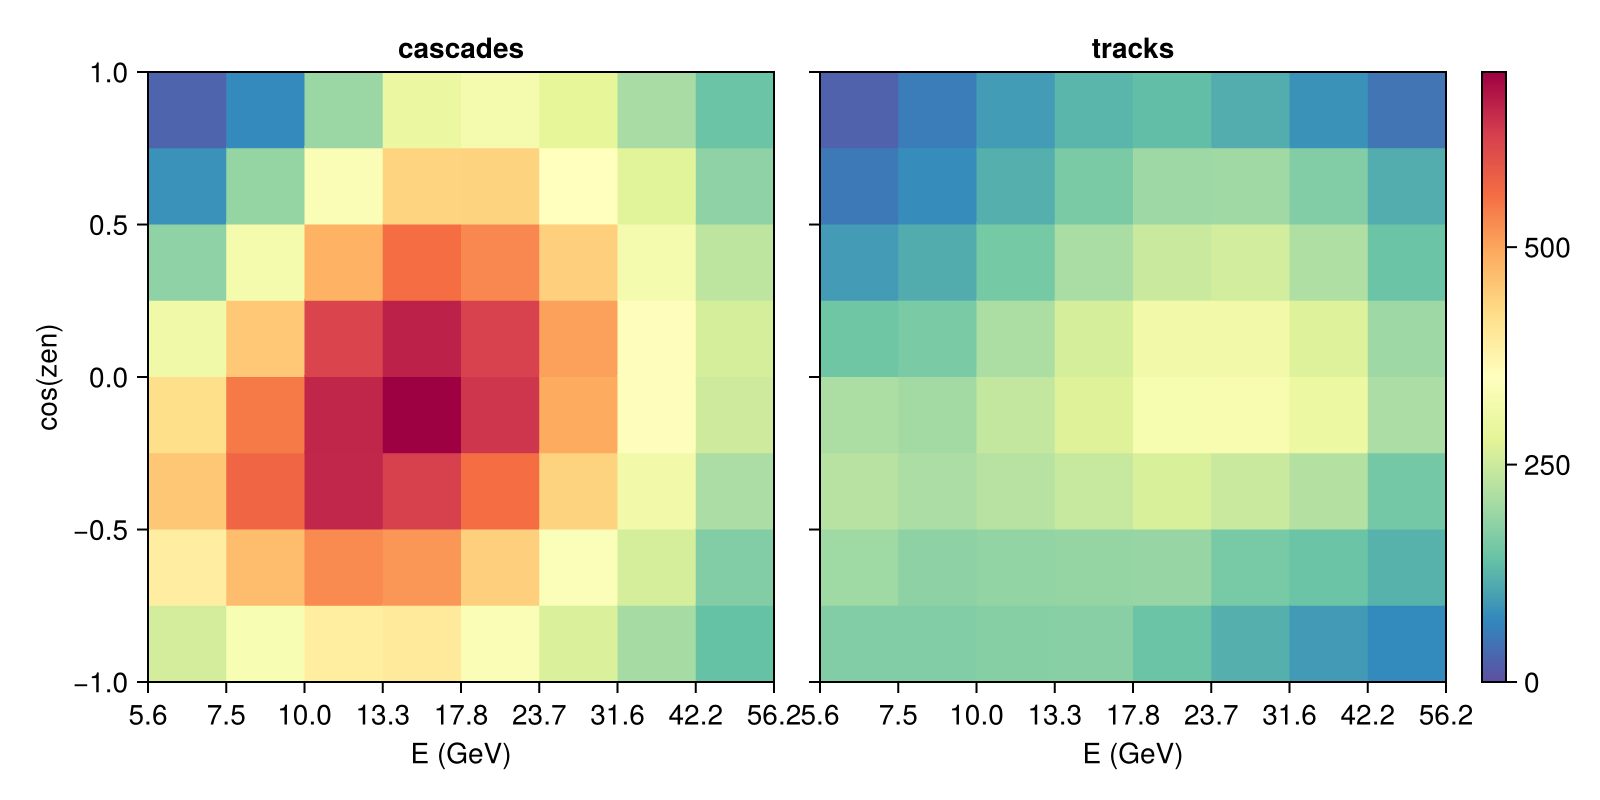

In [162]:
plotmap(expected)

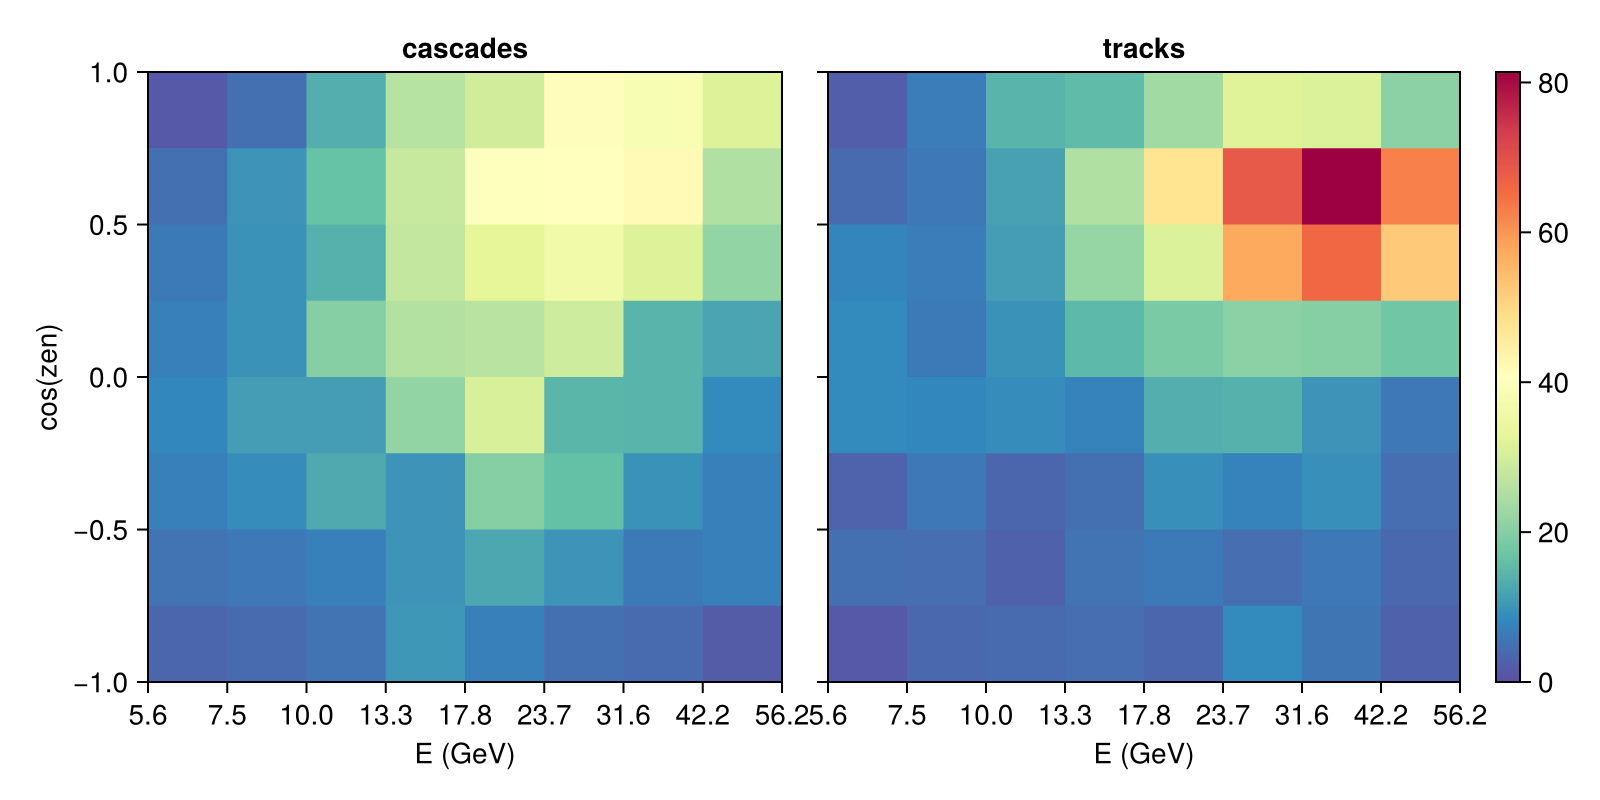

In [668]:
plotmap(muons["count"])

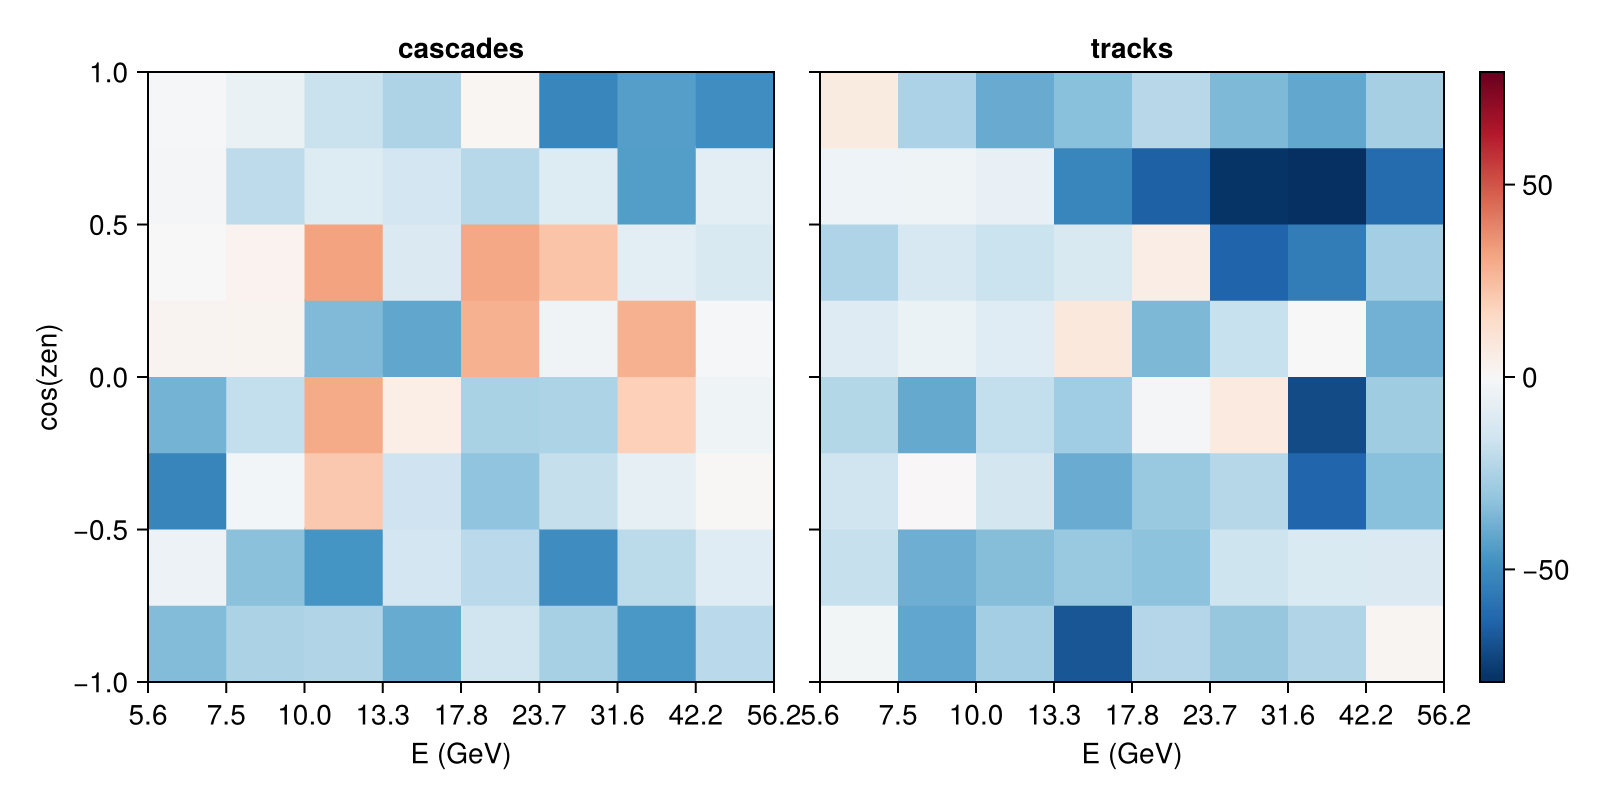

In [669]:
fig = plotmap((observed .- (expected .+ muons["count"])), colormap=Reverse(:RdBu), symm=true)

In [204]:
para_d = merge(Newtrinos.osc.standard.params, params_dict)

OrderedDict{Any, Any} with 20 entries:
  :θ₁₂                      => 0.587252
  :θ₁₃                      => 0.145426
  :θ₂₃                      => 0.855629
  :δCP                      => 1.0
  :Δm²₂₁                    => 7.53e-5
  :Δm²₃₁                    => 0.0024753
  :deepcore_lifetime        => 2.5
  :deepcore_atm_muon_scale  => 1.0
  :deepcore_ice_absorption  => 1.0
  :deepcore_ice_scattering  => 1.0
  :deepcore_opt_eff_overall => 1.0
  :deepcore_opt_eff_lateral => 0.0
  :deepcore_opt_eff_headon  => 0.0
  :nc_norm                  => 1.0
  :nutau_cc_norm            => 1.0
  :atm_flux_nunubar_ratio   => 1.0
  :atm_flux_nueumu_ratio    => 1.0
  :atm_flux_spectral_index  => 0.0
  :Barr_uphor_ratio         => 0.0
  :Barr_nu_nubar_ratio      => 0.0

In [205]:
prio_d = merge(Newtrinos.osc.standard.priors, priors)

OrderedDict{Any, Any} with 20 entries:
  :θ₁₂                      => Uniform{Float64}(a=0.420534, b=0.785398)
  :θ₁₃                      => Uniform{Float64}(a=0.1, b=0.2)
  :θ₂₃                      => Uniform{Float64}(a=0.523599, b=1.0472)
  :δCP                      => Uniform{Float64}(a=0.0, b=6.28319)
  :Δm²₂₁                    => Uniform{Float64}(a=6.5e-5, b=9.0e-5)
  :Δm²₃₁                    => Uniform{Float64}(a=0.002, b=0.003)
  :deepcore_lifetime        => Uniform{Float64}(a=2.0, b=4.0)
  :deepcore_atm_muon_scale  => Uniform{Float64}(a=0.0, b=2.0)
  :deepcore_ice_absorption  => Truncated(Normal{Float64}(μ=1.0, σ=0.1); lower=0…
  :deepcore_ice_scattering  => Truncated(Normal{Float64}(μ=1.0, σ=0.1); lower=0…
  :deepcore_opt_eff_overall => Truncated(Normal{Float64}(μ=1.0, σ=0.1); lower=0…
  :deepcore_opt_eff_lateral => Truncated(Normal{Float64}(μ=0.0, σ=1.0); lower=-…
  :deepcore_opt_eff_headon  => Uniform{Float64}(a=-5.0, b=2.0)
  :nc_norm                  => Truncated(Norma

In [674]:
prio_d = copy(para_d)

OrderedDict{Any, Any} with 21 entries:
  :deepcore_lifetime        => 2.5
  :deepcore_atm_muon_scale  => 1.0
  :deepcore_ice_absorption  => 1.0
  :deepcore_ice_scattering  => 1.0
  :deepcore_opt_eff_overall => 1.0
  :deepcore_opt_eff_lateral => 0.0
  :deepcore_opt_eff_headon  => 0.0
  :deepcore_aeff_scale      => 1.0
  :nc_norm                  => 1.0
  :nutau_cc_norm            => 1.0
  :atm_flux_nunubar_ratio   => 1.0
  :atm_flux_nueumu_ratio    => 1.0
  :atm_flux_spectral_index  => 0.0
  :Barr_uphor_ratio         => 0.0
  :Barr_nu_nubar_ratio      => 0.0
  :θ₁₂                      => 0.587252
  :θ₁₃                      => 0.145426
  :θ₂₃                      => 0.855629
  :δCP                      => 1.0
  :Δm²₂₁                    => 7.53e-5
  :Δm²₃₁                    => 0.0024753

In [675]:
collect(keys(prio_d))

21-element Vector{Any}:
 :deepcore_lifetime
 :deepcore_atm_muon_scale
 :deepcore_ice_absorption
 :deepcore_ice_scattering
 :deepcore_opt_eff_overall
 :deepcore_opt_eff_lateral
 :deepcore_opt_eff_headon
 :deepcore_aeff_scale
 :nc_norm
 :nutau_cc_norm
 :atm_flux_nunubar_ratio
 :atm_flux_nueumu_ratio
 :atm_flux_spectral_index
 :Barr_uphor_ratio
 :Barr_nu_nubar_ratio
 :θ₁₂
 :θ₁₃
 :θ₂₃
 :δCP
 :Δm²₂₁
 :Δm²₃₁

In [856]:
prio_d[:θ₂₃] = Newtrinos.osc.standard.priors[:θ₂₃]
prio_d[:Δm²₃₁] = Uniform(0.0015, 0.0035)

Uniform{Float64}(a=0.0015, b=0.0035)

In [202]:
vars_to_scan = (θ₂₃ = 10, Δm²₃₁=10)

(θ₂₃ = 10, Δm²₃₁ = 10)

In [206]:
@time result = Newtrinos.profile(l, prio_d, vars_to_scan, para_d);

[ Info: Setting new default BAT context BATContext{Float64}(Random123.Philox4x{UInt64, 10}(0x04fb6b97fe844991, 0x0fd89fcd94922718, 0x489722936e70b179, 0x551fe144aa3d49ff, 0xf2cfe3e2a56ae81c, 0xb1031c1ec50f7427, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0), HeterogeneousComputing.CPUnit(), BAT._NoADSelected())
[ Info: Setting new default BAT context BATContext{Float64}(Random123.Philox4x{UInt64, 10}(0xa6bd3c90734f6ecb, 0x04e4e0ba22137cb4, 0x7ac39a6d1a065cc8, 0x98d6449c373f1564, 0x9635d68438e56500, 0x546982b330fad32f, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0), HeterogeneousComputing.CPUnit(), BAT._NoADSelected())
[ Info: Setting new default BAT context BATContext{Float64}(Random123.Philox4x{UInt64, 10}(0xa86e11182b9af7f3, 0x8e82e8a7aa456b99, 0xf0f8c43e6713d183, 0xe9ee72518b3e5c5d, 0xa8ec2f3ca90629f7, 0x1d17a4e2c9e03253, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0), Heterog

14671.197369 seconds (353.55 M allocations: 98.502 TiB, 50.72% gc time, 24 lock conflicts, 0.55% compilation time)


In [852]:
@time result = Newtrinos.scan(l, prio_d, vars_to_scan, para_d, gradient_map=true);

215.618730 seconds (2.49 M allocations: 1.548 TiB, 46.77% gc time)


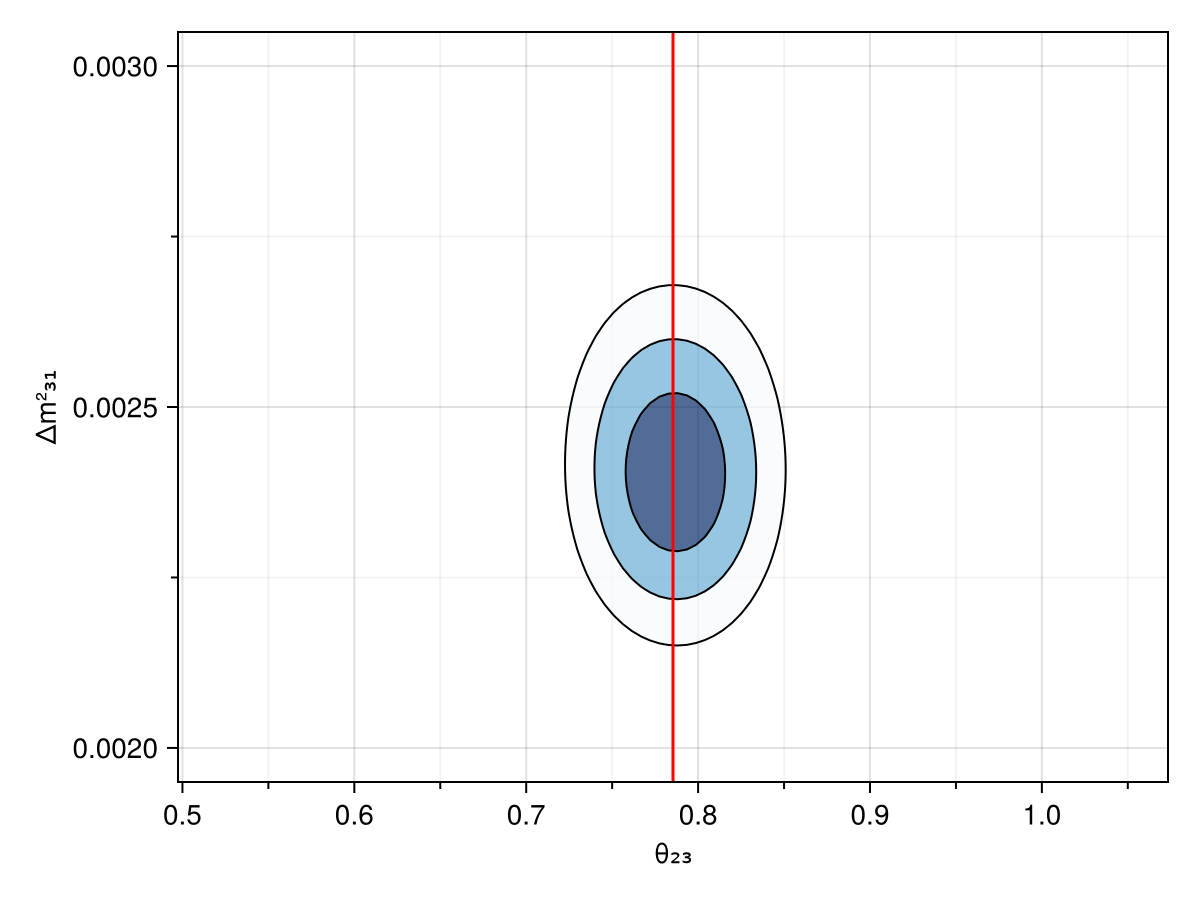

In [330]:
plot(result)
vlines!(pi/4, color=:red)
current_figure()

In [470]:
Newtrinos.bestfit(result)

(Barr_nu_nubar_ratio = 0.0, deepcore_opt_eff_lateral = 0.0, deepcore_opt_eff_overall = 1.0, atm_flux_spectral_index = 0.0, deepcore_ice_scattering = 1.0, deepcore_atm_muon_scale = 1.0, δCP = 1.0, θ₁₂ = 0.5872523687443223, deepcore_opt_eff_headon = 0.0, nc_norm = 1.0, atm_flux_nueumu_ratio = 1.0, Δm²₂₁ = 7.53e-5, deepcore_lifetime = 2.5, deepcore_aeff_scale = 1.0, nutau_cc_norm = 1.0, θ₁₃ = 0.1454258194533693, atm_flux_nunubar_ratio = 1.0, deepcore_ice_absorption = 1.0, Barr_uphor_ratio = 0.0, deepcore_atm_muon_scale_grad = -0.9221746200909617, deepcore_ice_absorption_grad = 31.149349115145316, δCP_grad = 0.6799845562466212, θ₁₂_grad = -0.15358428842968483, deepcore_opt_eff_lateral_grad = 40.07721121444658, nc_norm_grad = -24.328323112638287, deepcore_opt_eff_overall_grad = -247.31980438773766, θ₂₃_grad = -75.84540157286325, atm_flux_nueumu_ratio_grad = 27.116155565236017, Δm²₂₁_grad = 14377.960974177335, atm_flux_nunubar_ratio_grad = -44.63111844259988, θ₁₃_grad = -111.14150528965797, 

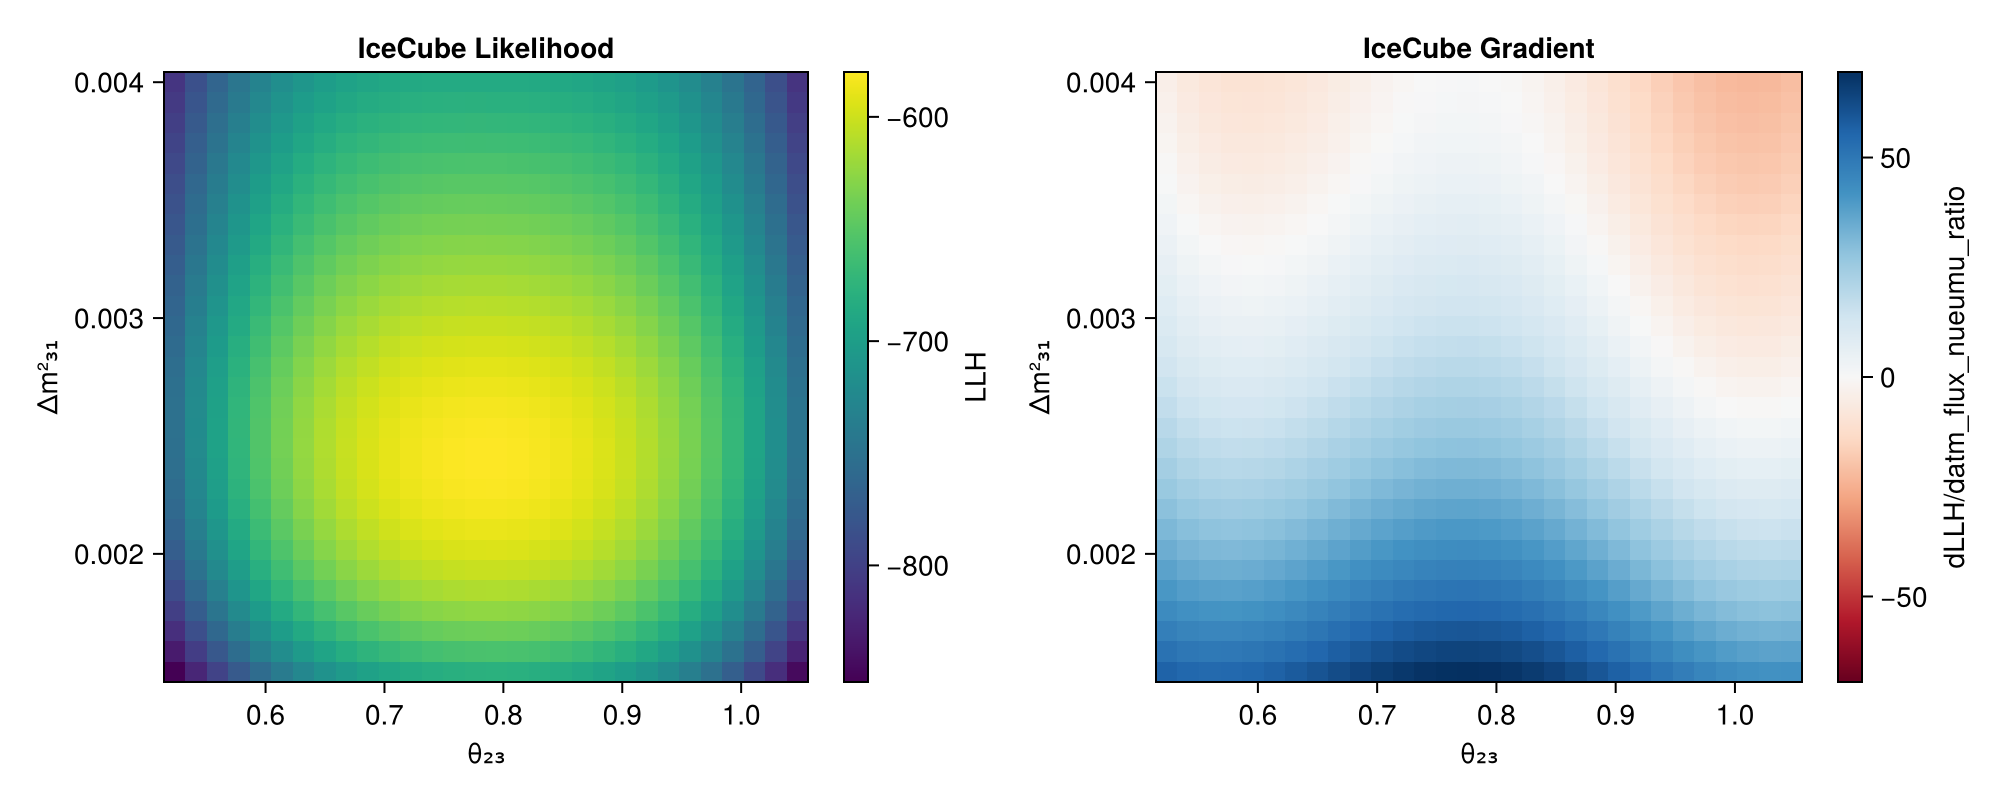

In [855]:
fig = Figure(size=(1000,400))
ax = Axis(fig[1,1], xlabel=String(keys(result.axes)[1]), ylabel=String(keys(result.axes)[2]), title="IceCube Likelihood")
hm = heatmap!(ax, result.axes[1], result.axes[2], result.values.llh)

Colorbar(fig[1,2], hm, label="LLH")
ax = Axis(fig[1,3], xlabel=String(keys(result.axes)[1]), ylabel=String(keys(result.axes)[2]), title="IceCube Gradient")
key = :atm_flux_nueumu_ratio 
h = result.values[Symbol(key, "_grad")]
colorrange = (-maximum(abs.(h)), maximum(abs.(h)))
hm = heatmap!(ax, result.axes[1], result.axes[2], h, colormap=:RdBu, colorrange=colorrange)
Colorbar(fig[1,4], hm, label="dLLH/d$(key)")
save("AD_test_IceCube.png", fig)
fig

In [205]:
using ArraysOfArrays

In [208]:
VA = VectorOfArrays{Number, 2}()

0-element VectorOfArrays{Number, 2, 1, Vector{Number}, Vector{Int64}, Vector{Tuple{Int64}}}

In [209]:
push!(VA, rand(2,2))

1-element VectorOfArrays{Number, 2, 1, Vector{Number}, Vector{Int64}, Vector{Tuple{Int64}}}:
 Number[0.5826789017939696 0.8230998463892565; 0.8400532131726357 0.2782831872814545]

In [210]:
push!(VA, rand(4,2))

2-element VectorOfArrays{Number, 2, 1, Vector{Number}, Vector{Int64}, Vector{Tuple{Int64}}}:
 Number[0.5826789017939696 0.8230998463892565; 0.8400532131726357 0.2782831872814545]
 Number[0.8680089887545899 0.9230963409582124; 0.7894882359744353 0.8552412422869538; 0.8577004102484459 0.9270983863027138; 0.7352722831665024 0.8374551405953808]

In [211]:
VA

2-element VectorOfArrays{Number, 2, 1, Vector{Number}, Vector{Int64}, Vector{Tuple{Int64}}}:
 Number[0.5826789017939696 0.8230998463892565; 0.8400532131726357 0.2782831872814545]
 Number[0.8680089887545899 0.9230963409582124; 0.7894882359744353 0.8552412422869538; 0.8577004102484459 0.9270983863027138; 0.7352722831665024 0.8374551405953808]

In [212]:
flatview(VA)

12-element Vector{Number}:
 0.5826789017939696
 0.8400532131726357
 0.8230998463892565
 0.2782831872814545
 0.8680089887545899
 0.7894882359744353
 0.8577004102484459
 0.7352722831665024
 0.9230963409582124
 0.8552412422869538
 0.9270983863027138
 0.8374551405953808

In [214]:
ArraysOfArrays.element_ptr(VA)

3-element Vector{Int64}:
  1
  5
 13

In [222]:
innermap(x -> (x,x), VA)

2-element VectorOfArrays{Tuple{Float64, Float64}, 2, 1, Vector{Tuple{Float64, Float64}}, Vector{Int64}, Vector{Tuple{Int64}}}:
 [(0.5826789017939696, 0.5826789017939696) (0.8230998463892565, 0.8230998463892565); (0.8400532131726357, 0.8400532131726357) (0.2782831872814545, 0.2782831872814545)]
 [(0.8680089887545899, 0.8680089887545899) (0.9230963409582124, 0.9230963409582124); (0.7894882359744353, 0.7894882359744353) (0.8552412422869538, 0.8552412422869538); (0.8577004102484459, 0.8577004102484459) (0.9270983863027138, 0.9270983863027138); (0.7352722831665024, 0.7352722831665024) (0.8374551405953808, 0.8374551405953808)]

In [221]:
VA[1]

2×2 reshape(view(::Vector{Number}, 1:4), 2, 2) with eltype Number:
 0.582679  0.8231
 0.840053  0.278283